# Подготовка данных

Установим необходимые библиотеки

In [1]:
# #Установим keras (если необходимо)
# !pip install keras

# #Установим tensorflow (если необходимо)
# !pip install tensorflow

# #Установим библиотеку для отображения изменения accuracy и loss
# !pip install livelossplot

Импорт библиотек

In [2]:
#Загрузим необходимые библиотеки

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
import cv2
from imageio import imread

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.compiler.tensorrt import trt_convert as trt

from livelossplot.tf_keras import PlotLossesCallback

In [3]:
# #Если работаем через google disk
# #Подключимся к диску с данными
# from google.colab import drive
# drive.mount('/content/gdrive')
# dir_path = '/content/gdrive/MyDrive/NN_Emotion'

#Если работаем через JupiterNotebook
dir_path = '.'

In [4]:
#Создадим путь до файлов train
base_dir = Path(dir_path + '/train')

In [5]:
#Загрузим датасет
train_df = pd.read_csv(dir_path + '/train.csv', sep=',').set_index('Unnamed: 0')

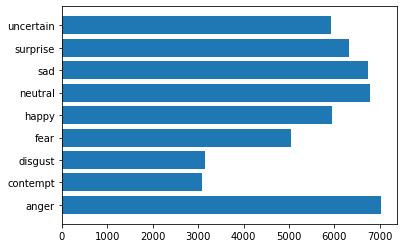

In [6]:
#Посмотрим на распределение признаков

plt.barh(train_df.groupby('emotion').count().index, train_df.groupby('emotion').count()['image_path'])
plt.show()

-----

Подготовим различные дополнительные функции

In [7]:
#Функция для отображения человека и эмоции
def human_emotion_show(images, labels, predicted_labels=None):
    names = {v:k for k, v in train_data.class_indices.items()} #Словарь с эмоциями (ключ:значение -> значение:ключ)
    
    fig = plt.figure(figsize=(12,12))
    for i in range(20):
        plt.subplot(5,5, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.gray)
        
        if predicted_labels is not None:
            title_obj = plt.title(
                f'Real: {names[np.argmax(labels[i])]} \n Pred: {names[np.argmax(predicted_labels[i])]}'
            )
            if np.argmax(labels[i]) != np.argmax(predicted_labels[i]):
                plt.setp(title_obj, color='r')
        else:
            plt.title(f"Emotion: {names[np.argmax(labels[i])]}")
    fig.tight_layout()
    


#Функция для предобработки изображения для prediction
def prepare_image(img, new_size):
    #Конвертирование в Ч/Б
    img = tf.image.rgb_to_grayscale(img)
    
    #Изменение размера
    img = tf.image.resize(img, new_size) /255.
    return np.array(img)





------

# Нейронная сеть

Напишем архитектуру нейронной сети состоящию из нескольких conv и pooling слоёв.




---



In [8]:
#Зададим размер batch и размер изображения
BATCH_SIZE = 32
IMG_SHAPE  = 48

Препроцессинг и аугментация.

In [9]:
#Создадим необходимые train (80%) и validation (20%) datasets
#Зададим некоторые параметры аугментации

data_image_gen = ImageDataGenerator(rescale=1./255,
                                    rotation_range=40, #Добавить поворот
                                    shear_range=0.2, #Добавить сдвиг
                                    zoom_range=0.2, #Добавить увеличение
                                    horizontal_flip=True, #Добавить зеркальный поворот
                                    fill_mode="nearest", #Заполняем пробелы
                                    validation_split=0.2)

train_data = data_image_gen.flow_from_directory(batch_size=BATCH_SIZE, 
                                                directory=base_dir, 
                                                shuffle=True, 
                                                target_size=(IMG_SHAPE,IMG_SHAPE), 
                                                class_mode='categorical', 
                                                color_mode = "grayscale", #Ч/Б
                                                subset='training')

valid_data = data_image_gen.flow_from_directory(batch_size=BATCH_SIZE, 
                                                directory=base_dir, 
                                                shuffle=True, 
                                                target_size=(IMG_SHAPE,IMG_SHAPE), 
                                                class_mode='categorical', 
                                                color_mode = "grayscale", #Ч/Б
                                                subset='validation')

Found 40039 images belonging to 9 classes.
Found 10007 images belonging to 9 classes.


In [10]:
#Изображения и лэйблы
train_images, train_labels = next(train_data)
val_images, val_labels = next(valid_data)

print(f' Размер train_data: {train_images.shape}','\n', f'Размер train_labels: {train_labels.shape}','\n')
print(f' Размер validation_data: {val_images.shape}','\n', f'Размер validation_labels: {val_labels.shape}')

 Размер train_data: (32, 48, 48, 1) 
 Размер train_labels: (32, 9) 

 Размер validation_data: (32, 48, 48, 1) 
 Размер validation_labels: (32, 9)


In [11]:
#Количество определенных эмоций (по сути, кол-во классов)
n_emotions = train_labels.shape[1]
n_emotions

9

Сверточная нейронная сеть

In [12]:
#Модель
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape = (IMG_SHAPE, IMG_SHAPE, 1)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2), strides=(2,2)),
    
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2), strides=(2,2)),

    tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2), strides=(2,2)),

    tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(512, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2), strides=(2,2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dropout(0.5), #Прореживаем нс для исключения переобучения
    
    tf.keras.layers.Dense(n_emotions, activation="softmax"),
])


#Параметры модели
optim = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=1e-6)
loss = tf.keras.losses.CategoricalCrossentropy()
metric = tf.keras.metrics.categorical_accuracy

#Компиляция
model.compile(optimizer=optim, 
              loss=loss, 
              metrics=metric)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 46, 46, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 44, 44, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 22, 22, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 22, 22, 128)       73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 20, 20, 128)       147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 10, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 10, 10, 256)       2

In [15]:
#Сохраним наилучший результат модели

model_best_path = Path(dir_path + '/model_best_var1')
model_best_path.mkdir(exist_ok=True)

model_best_filename = 'checkpoint_best.h5'  
model_best_path_total = str(model_best_path/model_best_filename)

checkpoint = tf.keras.callbacks.ModelCheckpoint(model_best_path_total, 
                                                monitor='val_accuracy', 
                                                verbose=1, 
                                                save_best_only=True, 
                                                mode='max')

**Обучение модели**

___

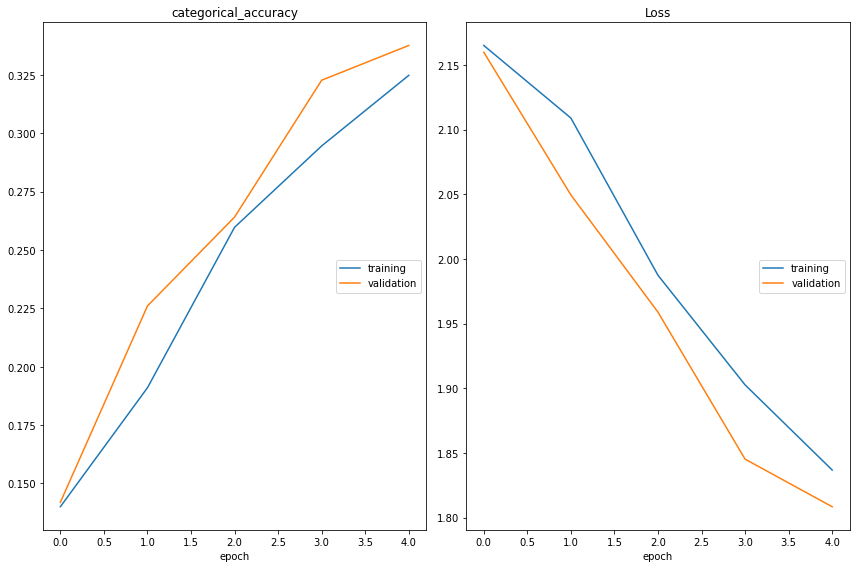

categorical_accuracy
	training         	 (min:    0.140, max:    0.325, cur:    0.325)
	validation       	 (min:    0.142, max:    0.338, cur:    0.338)
Loss
	training         	 (min:    1.837, max:    2.165, cur:    1.837)
	validation       	 (min:    1.808, max:    2.160, cur:    1.808)
1252/1252 [==============================] - 1486s 1s/step - loss: 1.8368 - categorical_accuracy: 0.3249 - val_loss: 1.8084 - val_categorical_accuracy: 0.3377


In [29]:
EPOCHS = 5

history = model.fit(train_data, 
                    validation_data=valid_data, 
                    epochs=EPOCHS, 
                    callbacks=[checkpoint, PlotLossesCallback()])

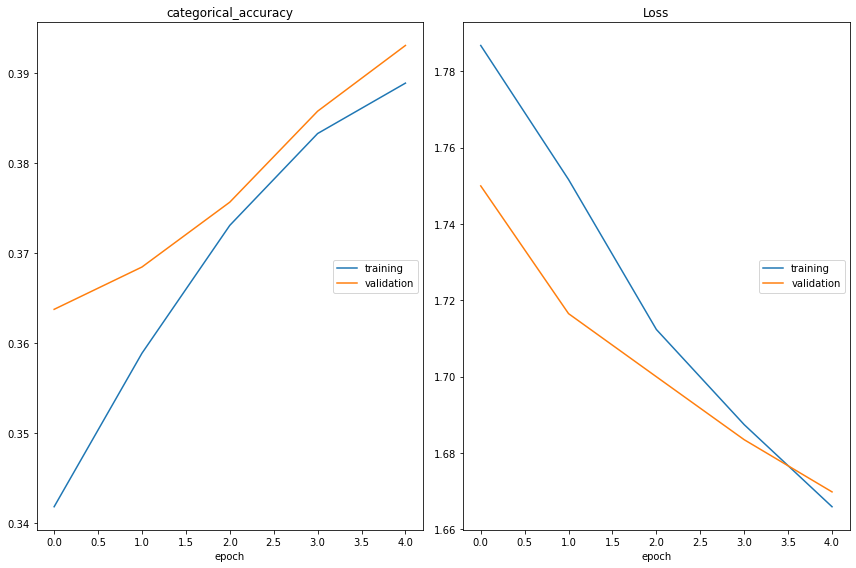

categorical_accuracy
	training         	 (min:    0.342, max:    0.389, cur:    0.389)
	validation       	 (min:    0.364, max:    0.393, cur:    0.393)
Loss
	training         	 (min:    1.666, max:    1.787, cur:    1.666)
	validation       	 (min:    1.670, max:    1.750, cur:    1.670)
1252/1252 [==============================] - 1491s 1s/step - loss: 1.6659 - categorical_accuracy: 0.3888 - val_loss: 1.6698 - val_categorical_accuracy: 0.3930


In [30]:
#Сделаем ещё одну итерацию с 5 эпохами
EPOCHS = 5

history = model.fit(train_data, 
                    validation_data=valid_data, 
                    epochs=EPOCHS, 
                    callbacks=[checkpoint, PlotLossesCallback()])

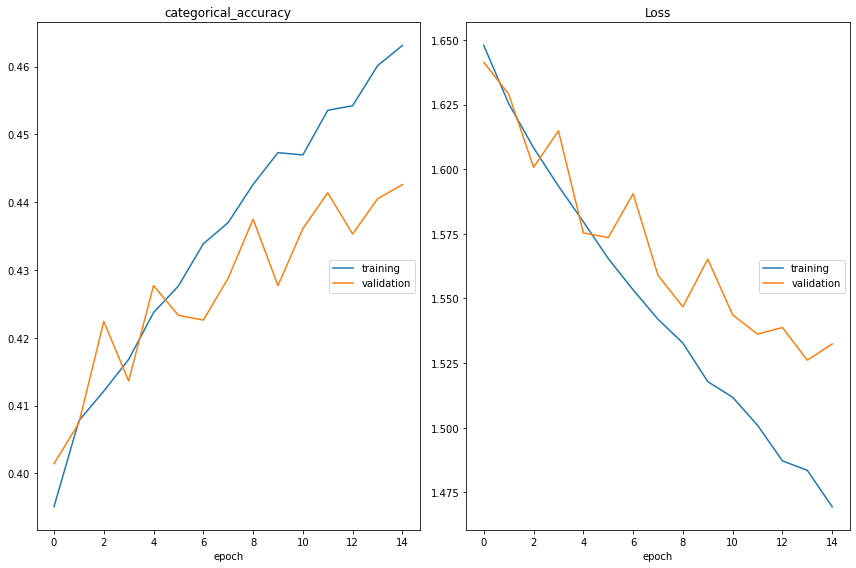

categorical_accuracy
	training         	 (min:    0.395, max:    0.463, cur:    0.463)
	validation       	 (min:    0.401, max:    0.443, cur:    0.443)
Loss
	training         	 (min:    1.469, max:    1.648, cur:    1.469)
	validation       	 (min:    1.526, max:    1.641, cur:    1.532)
1252/1252 [==============================] - 1531s 1s/step - loss: 1.4694 - categorical_accuracy: 0.4631 - val_loss: 1.5324 - val_categorical_accuracy: 0.4426


In [16]:
#Сделаем последнюю итерацию с 15 эпохами
EPOCHS = 15

history = model.fit(train_data, 
                    validation_data=valid_data, 
                    epochs=EPOCHS, 
                    callbacks=[checkpoint, PlotLossesCallback()])

In [18]:
#Сохранить веса (если возникли сложности с чекпоинтом)
model.save(dir_path + '/model_best_var1/' + model_best_filename)

In [22]:
#Сохранить модель
model.save(dir_path + '/model_best_var1/best_model')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ./model_best_var1/best_model/assets


**Выводы**

Обучение проходило на 25 эпохах (к 25 эпохе точность на валидации выходит на плато). Измение loss и accuracy видно на графиках. Наилучшая точность на валидации составляет 44,3%. Сохранив модель, посмотрим на время инференса.

---

Посмотрим на результаты работы модели

In [13]:
#Загрузим веса
model.load_weights(dir_path + '/model_best_var1/checkpoint_best.h5')

# #Загрузить модель
# model = tf.keras.models.load_model(dir_path + '/model_best_var1/best_model')

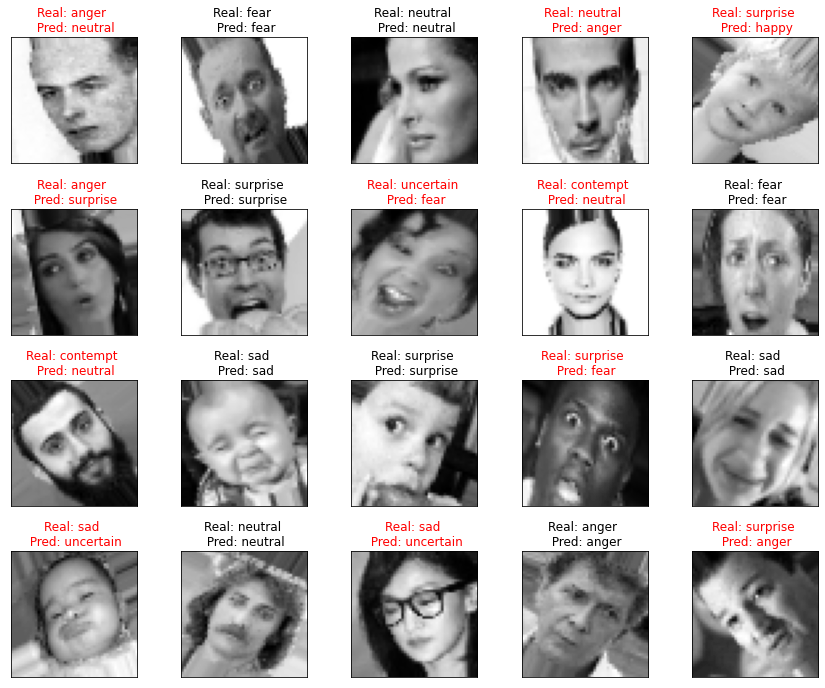

In [19]:
#Предсказание модели
val_predictions = model.predict(val_images)

#Визуализация
human_emotion_show(val_images, val_labels, val_predictions)

# Инференс модели

Возьмем одно изображение из тестовых данных и посмотрим на скорость инференса.

In [20]:
img = np.empty((1, 48, 48, 1)) #Заготовка под картинку

#Чтение картинки (Необходимо взять любую картинку с лицом для теста инференса)
img_test = cv2.imread(dir_path + 'test_img.jpg')

#Обработка
img_test = prepare_image(img_test,(48,48))

#Конвертация в нужный формат
img[0] = img_test

Посмотрим на скорость инференса

In [21]:
%%timeit -n 10 -r 10

model.predict(img)

33.1 ms ± 3.35 ms per loop (mean ± std. dev. of 10 runs, 10 loops each)


Скорость достаточно высокая. Но попробуем сделать модель ещё быстрее с помощью TensorRT.

**TensorRT**

In [23]:
#Загрузим нашу модель
converter = trt.TrtGraphConverterV2(input_saved_model_dir=dir_path + '/model_best_var1/best_model')

#Ускорим с помощью TensorRT
converter.convert()

#Сохраним ускоренную модель
converter.save(dir_path + '/model_best_var1/checkpoint_best_trt') 

INFO:tensorflow:Linked TensorRT version: (0, 0, 0)
INFO:tensorflow:Loaded TensorRT version: (0, 0, 0)
INFO:tensorflow:Assets written to: ./model_best_var1/checkpoint_best_trt/assets


Посмотрим время ускоренной модели

In [24]:
#Загрузим ускоренную модель
trt_model = tf.keras.models.load_model(dir_path + '/model_best_var1/checkpoint_best_trt')

In [25]:
%%timeit -n 10 -r 10

trt_model(img.astype('float32'))

8.03 ms ± 2.79 ms per loop (mean ± std. dev. of 10 runs, 10 loops each)


# Выводы по всей работе

Модель показала не плохие результаты.

Обучено 25 эпох.

Одна эпоха обучается около 25 минут. 

На валидационной выборке **точность 44.3%**, loss 1.53. 

Время инференса до ускорения 0,33 секунды

Время инференса после ускорения 0,08 секунды